# Supplementary Materials

"Background-dependent selection of genetic variation in heterogeneous populations"

Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 2 - Heterogeneity (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figure 2 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [15]:
# load external dependencies
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as lines
from matplotlib.ticker import FuncFormatter,MaxNLocator
import matplotlib.patheffects as PathEffects
%matplotlib inline

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation

# load internal dependencies
import colors,plot,model,utils,config
from paths import * # absolute file path for data directory

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
labels = pd.read_csv(dir_data+'seq/sample_labels_merged.csv')

labels.loc[labels.clone.isnull(),'type'] = 'population'
labels.loc[labels.clone.notnull(),'type'] = 'clone'

print labels['coverage'].quantile(.25), labels['coverage'].quantile(.75)

23.472806495 88.212483005


## Data import

Top panels - Import subclonal frequency

In [18]:
# load data
seq_st_df = utils.load_data(dir_data+'seq/background/seq_background.pickle')

# compute cumulative haplotype frequencies for major subclones
seq_st_df['clonal'] = seq_st_df.apply(lambda row: 
                                      row[['subclone A','subclone B','subclone C','subclone D']].fillna(0).sum(), 
                                      axis=1)
# calculate the remaining bulk fraction
seq_st_df['bulk'] = 1.0 - seq_st_df['clonal']

seq_st_df.head()

,background,cross,cross_rep,selection,selection_rep,subclone A,subclone B,subclone C,subclone D,time,population,sample,clonal,bulk
0,WAxNA,F12,2,RM,2,0.0200,NaN,NaN,NaN,2,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T2,0.0200,0.9800
1,WAxNA,F12,2,RM,2,0.0200,NaN,NaN,NaN,4,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T4,0.0200,0.9800
2,WAxNA,F12,2,RM,2,0.0705,NaN,NaN,NaN,8,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T8,0.0705,0.9295
3,WAxNA,F12,2,RM,2,0.1196,NaN,NaN,NaN,16,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T16,0.1196,0.8804
4,WAxNA,F12,2,RM,2,0.1098,NaN,NaN,NaN,32,WAxNA_F12_2_RM_2,WAxNA_F12_2_RM_2_T32,0.1098,0.8902


Middle panels - Import mutation counts

In [19]:
# load data
seq_lineage = utils.load_data(dir_data+'seq/de-novo/seq_de_novo.pickle')
seq_lineage.protein_position = seq_lineage.protein_position.apply(str)
isec1 = utils.load_data(dir_data+'seq/de-novo/seq_dn_df_isec1.pickle')
isec1 = isec1[isec1.gene.isin(['RNR2','RNR4','FPR1','TOR1'])]
isec2 = utils.load_data(dir_data+'seq/de-novo/seq_dn_df_isec2.pickle')

# seq_dn_df = seq_dn_df[seq_dn_df['population'].notnull()]

seq_dn_df = pd.concat([isec1,isec2]).drop_duplicates(subset=['population','sample','chrom','pos','gene',
                                                             'cds_position','substitution',
                                                             'protein_position','amino_acids'])

seq_dn_df = seq_dn_df.reset_index(drop=True)

seq_dn_df = pd.merge(seq_dn_df, seq_lineage[['population','sample','gene','protein_position','amino_acids','assignment']], 
                     on=['population','sample','gene','protein_position','amino_acids'], how='left')

# seq_dn_df = pd.merge(seq_dn_df, seq_lineage[['population','gene','assignment']], 
#                      on=['population','gene'], how='left')

# seq_dn_df.loc[seq_dn_df.assignment.isnull(),'assignment'] = 'bulk'

seq_dn_df.loc[seq_dn_df.gene.isin(['RNR2','RNR4','FPR1','TOR1']),'mutation_type'] = 'driver'
seq_dn_df.loc[~seq_dn_df.gene.isin(['RNR2','RNR4','FPR1','TOR1']),'mutation_type'] = 'passenger'

seq_dn_df.loc[seq_dn_df.assignment.isnull(),'assignment'] = 'bulk'

# Keep mutations that occur in >1 population per environment
# seq_dn_df = seq_dn_df.groupby(['population']).filter(lambda x: x.sample_30.nunique() > 1)

# Coarse-grained categories of functional effects
dict_consequence_long = {
'missense_variant': 'non-synonymous', 
'stop_gained': 'non-synonymous', 
'synonymous_variant': 'synonymous', 
'initiator_codon_variant': 'synonymous',
'frameshift_variant': 'non-synonymous',
'inframe_insertion': 'non-synonymous',
'inframe_deletion': 'non-synonymous',
}
seq_dn_df['consequence_short'] = seq_dn_df['consequence'].map(dict_consequence_long)

seq_dn_df = seq_dn_df.reset_index(drop=True)

utils.save_data(seq_dn_df, dir_data+'seq/de-novo/seq_dn_df_consensus.pickle')

# seq_dn_df['frequency'].apply(lambda x: True if x <= 0.1 else False)

# groups = seq_dn_df.groupby(by=['population','gene','cds_position','substitution','protein_position','amino_acids','consequence_short'])#,'chrom','pos','ref','alt'])
# y = groups.apply(lambda g: True if (g[g['time'] == '2'].frequency < 0.05).any() else False)#g['B'].max()]))

# seq_dn_df = seq_dn_df.loc[y.values]#.reset_index()

seq_dn_df.head()

,ac,af,alt,an,allele,amino_acids,biotype,baseqranksum,cds_position,chrom,...,time,clone,sample,population,coverage,missing,substitution,assignment,mutation_type,consequence_short
0,1,0.1,[A],10,A,K/M,protein_coding,-0.011,341,7,...,2,,NA_HU_1_T2,NA_HU_1,46.969315,NaN,T>A,bulk,driver,non-synonymous
1,1,0.1,[A],10,A,K/M,protein_coding,-0.011,341,7,...,4,,NA_HU_1_T4,NA_HU_1,39.970174,NaN,T>A,bulk,driver,non-synonymous
2,1,0.1,[A],10,A,K/M,protein_coding,-0.011,341,7,...,8,,NA_HU_1_T8,NA_HU_1,46.222596,NaN,T>A,bulk,driver,non-synonymous
3,1,0.1,[A],10,A,K/M,protein_coding,-0.011,341,7,...,16,,NA_HU_1_T16,NA_HU_1,28.537800,NaN,T>A,bulk,driver,non-synonymous
4,1,0.1,[A],10,A,K/M,protein_coding,-0.011,341,7,...,32,,NA_HU_1_T32,NA_HU_1,49.274111,NaN,T>A,bulk,driver,non-synonymous


Bottom panels - Import phenotype evolution

In [24]:
# load data
pheno_abs_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_abs.pickle')
pheno_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_norm.pickle')

# filter out strains used for spatial control
pheno_df = pheno_df[(pheno_df.group == 'ancestral')|\
                    (pheno_df.group == 'evolved')]

groups_1 = pheno_df.groupby(['group','cross','cross_rep','selection','selection_rep'])
pheno_df = pheno_df[pheno_df.selection_rep != '']

for (ii,((group,cross,cross_rep,selection,selection_rep),g1)) in enumerate(groups_1):
    
    if group=='evolved':
        df = groups_1.get_group(('ancestral',cross,cross_rep,selection,''))        
        df.selection_rep = df.selection_rep.replace([''],[selection_rep])
        df.population = df['background']+'_'+df['cross']+'_'+df['cross_rep'].apply(str)+'_'+df['selection']+'_'+df['selection_rep'].apply(str)

        pheno_df = pheno_df.append(df)
        
pheno_df = pheno_df.reset_index(drop=True)
        
# # filter out measurement replicates with >5% measurement error
# pheno_df['pct'] = pheno_df.groupby(['selection','environment','group',\
#                                     'population','isolate','genotype_long'])['growth_rate']\
# .apply(lambda x: (x-x.mean())/float(x.mean()))
# pheno_df = pheno_df[abs(pheno_df['pct'])<0.05]

pheno_df.head()  # show dataframe header to stdout

,selection,environment,run,index,plate,row,column,id,id_plate,group,...,assignment,isolate,gene,genotype_short,genotype_long,amino_acids,mating,auxotrophy,doubling_time,growth_rate
0,RM,RM,1,2,0,0,2,P6_A1,6,evolved,...,,1,,+/+,,,MATa/α,,0.039118,0.973249
1,RM,RM,1,3,0,0,3,P7_A1,7,evolved,...,,1,,+/+,,,MATa/α,,-0.802399,1.743999
2,RM,RM,1,6,0,0,6,P6_A2,6,evolved,...,,2,,+/+,,,MATa/α,,-0.496987,1.411263
3,RM,RM,1,7,0,0,7,P7_A2,7,evolved,...,,2,,+/+,,,MATa/α,,-0.816278,1.760858
4,RM,RM,1,10,0,0,10,P6_A3,6,evolved,...,,3,,+/+,,,MATa/α,,-0.440344,1.356928


In [11]:
# # load data
# order=['selection','environment','run','index','plate','row','column','group',
#        'population','background','ploidy','cross','cross_rep','selection_rep','time','assignment','isolate',
#        'gene','genotype_short','genotype_long','amino_acids','mating','auxotrophy','growth_rate']#,'lag','yield']
# pheno_df = utils.load_data(dir_data+'pheno/populations/pheno_populations_norm.pickle')
# # [k.replace('(','').replace(')','').replace('-','').replace('__','_').replace(' ','_') for k in pheno_df.columns]
# # pheno_df['population'] = pheno_df['background']+'_'+pheno_df['cross']+'_'+pheno_df['cross_rep'].apply(str)+'_'+pheno_df['selection']+'_'+pheno_df['selection_rep'].apply(str)
# pheno_df = pheno_df.sort_values(['selection','environment','run','index','plate','row','column'])
# pheno_df[order].to_csv(dir_data+'pheno/populations/pheno_populations_norm.csv', index=False, encoding='utf-8')

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


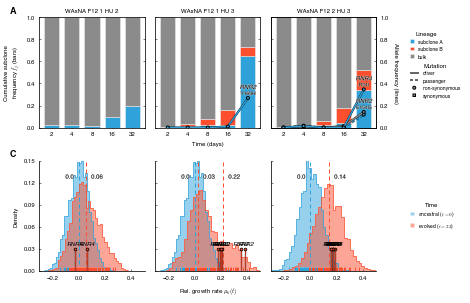

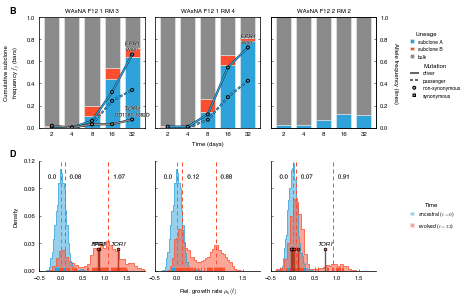

In [25]:
param = 'growth_rate'

dict_panels = {
    'WAxNA_F12_1_HU_2':0,
    'WAxNA_F12_1_HU_3':1,
    'WAxNA_F12_2_HU_3':2,
    'WAxNA_F12_1_RM_3':0,
    'WAxNA_F12_1_RM_4':1,
    'WAxNA_F12_2_RM_2':2
}

groups_st = seq_st_df[seq_st_df.population.isin(dict_panels.keys())]
groups_dn = seq_dn_df[(seq_dn_df.population.isin(dict_panels.keys()))&\
                      (seq_dn_df.clone=='')]
groups_ph = pheno_df[pheno_df.population.isin(dict_panels.keys())]

groups_st = groups_st.groupby('selection')
groups_dn = groups_dn.groupby('selection')
groups_ph = groups_ph.groupby(['selection','environment'])

for (ii, env) in enumerate(['HU','RM']):
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), dpi=300, sharey='row')
    
    fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,hspace=0.3,wspace=0.1)
    
    # set scales
    for ax in axes[0]:
        ax.set_xlim(0, 32)
        ax.set_ylim(0, 1)
    for ax in axes[1]:
        if env=='HU':
            ax.set_xlim(-0.3, 0.5)
            ax.set_ylim(0, 0.15)
        elif env=='RM':
            ax.set_xlim(-0.5, 1.9)
            ax.set_ylim(0, 0.12)

    ### top panels ###
    # de novo mutations #
    for (jj, (population, gdn)) in enumerate(groups_dn.get_group(env).groupby('population')):
        
        # retrieve axes
        ax1 = axes[0][dict_panels[population]]
        
        for (gene, cds_pos, sub, protein_pos, amino_acids, consequence), gdx in \
    gdn.groupby(['gene','cds_position','substitution','protein_position','amino_acids','consequence_short']):
        
            assignment = gdx.assignment.unique()[0]
            mutation_type = gdx.mutation_type.unique()[0]
            
            gdx.time = gdx.time.apply(int)
            gdx = gdx.sort_values('time').reset_index(drop=True)
            gdx = gdx.sort_index()
            
            ax1.plot(gdx.index.values, gdx.frequency.values,
                     color=config.dict_lineages[assignment]['fill'], 
                     **utils.merge_two_dicts(config.dict_mutation_type[mutation_type],
                                             config.dict_consequence_short[consequence]))
            
            if mutation_type=='driver':
                index = np.argmax(gdx.frequency)
                ax1.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                             textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                ax1.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                             xy=(index,gdx.frequency[index]), fontsize=5,
                             textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                             path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)
    
    # subclonal frequency #
    for (jj, (population,gst)) in enumerate(groups_st.get_group(env).groupby('population')):

        # retrieve axes
        ax2 = axes[0][dict_panels[population]]

        # 
        ax2.set_title(population.replace('_',' '), fontsize=6)
        # 
        gst.set_index('time', inplace=True)
        colors=[config.dict_lineages[x]['fill'] for x in ['subclone A','subclone B','bulk']]
        gst[['subclone A','subclone B','bulk']].plot(ax=ax2, kind='bar', legend=False, 
                                                     stacked=True, rot=0, width=0.75, position=0.5,
                                                     color=colors)
        
        # rotate the x-axis ticks
        ax2.set_xlabel('', rotation=0)

    ### bottom panels ###
    for (jj, (population,gph)) in enumerate(groups_ph.get_group((env,env)).groupby('population')):

        # retrieve axes
        ax3 = axes[1][dict_panels[population]]
        utils.simple_axes(ax3)
        # take rows where param is finite
        gph = gph[np.isfinite(gph[param])]
        # set reference as mean phenotype of the ancestral hybrid
        ref = gph.groupby('group').get_group('ancestral')[param].mean()
        gph.loc[:,param] = gph[param] - ref
                            
        for (kk, (time, g3)) in enumerate(gph.groupby('group')):
            
            x, y = plot.histogram_binned_data(ax, g3[param], bins=34)

            ax3.plot(x, y, linewidth=0.75)
            
            ax3.fill_between(x, 0, y, label=config.dict_population['long_label'][time], 
                             alpha=0.5, facecolor=config.dict_population['color'][time])
            
            data_reduced = g3.groupby('isolate').agg([np.mean])
            X = data_reduced[param]['mean'][:, np.newaxis]
            N = np.arange(1, 6)
            
            models = model.gmm_fit(X, N)
            
            # compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            
            M_best = models[np.argmin(BIC)]
        
            # mean of the distribution
            for p in abs(M_best.means_.ravel()):
                ax3.plot( [p,p], ax3.get_ylim(), 
                         color=config.dict_population['color'][time], 
                         linestyle='--', dashes=(4,3), linewidth=1)
                pos = ax3.get_ylim()[0] * 0.75 + ax3.get_ylim()[1] * 0.25
                trans = ax3.get_xaxis_transform() # x in data units, y in axes fraction                    
                ax3.annotate(np.around(p, 2),
                            xy=(p, 0.85), xycoords=trans, fontsize=6,
                            color='k', va='center',
                            ha=('right' if time=='ancestral' else 'left'),
                            xytext=((-5 if time=='ancestral' else 5),0), textcoords='offset points',
                            path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
            
            data_ns = g3.groupby(['isolate']).agg([np.mean, np.median, np.std, 'count'])
            
            x_data = np.array(data_ns[param]['mean'])
            y_data = np.repeat([0.03*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
            
            markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                            
            plt.setp(markerline, 'markerfacecolor', config.dict_population['color'][time], markersize = 0)
            plt.setp(stemlines, linewidth=1, color=config.dict_population['color'][time], 
                     path_effects=[PathEffects.withStroke(linewidth=0.75, foreground="w")])
            plt.setp(baseline, 'color', 'none')

            # mean of sequenced isolates       
            data_ys = g3[(g3['group']=='evolved')&\
                         (g3['assignment']!='')].groupby(['isolate','gene','genotype_long','assignment'])
            
            data_ys = data_ys.agg([np.mean, np.median, np.std, 'count'])
            
            if len(data_ys)>0:
            
                x_data = np.array(data_ys[param]['mean'])
                y_data = np.repeat([0.2*(ax3.get_ylim()[1]-ax3.get_ylim()[0])], len(x_data))
                arr = zip(x_data, y_data)
            
                markerline, stemlines, baseline = ax3.stem(x_data, y_data)
                
                plt.setp(markerline, 'color', config.dict_population['color'][time], 
                         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
                plt.setp(stemlines, linewidth=.75, color=config.dict_population['color'][time],
                         path_effects=[PathEffects.withStroke(linewidth=1.25, foreground='k')], zorder=2)  
                plt.setp(baseline, 'color', 'none', zorder=1)
                    
            for idx, label in data_ys.iterrows():
    
                ax3.annotate(label.name[1], 
                             xy = (label[param]['mean'], 0.2), xycoords=('data','axes fraction'), 
                             xytext = (0, 8), textcoords = 'offset points', 
                             ha = 'center', va = 'top',
                             fontsize = 6, style = 'italic')#,
#                              path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
        
    # set axes labels
    axes[0, 1].set_xlabel('Time (days)')
    axes[0, 0].set_ylabel('Cumulative subclone\n frequency $f_j$ (bars)')
    axes[0, 2].twinx().set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')
    axes[1, 1].set_xlabel(r'Rel. growth rate $\mu_{k}(t)$')
    axes[1, 0].set_ylabel('Density')

    # set legends
    leg1 = axes[0, 2].legend(bbox_to_anchor=(1.3, 0.75), frameon=False,
                             loc='center left', borderaxespad=0.,
                             handlelength=0.75, title='Lineage', prop={'size':5})

    driver_artist = lines.Line2D((0,1),(0,0), color=config.dict_lineages['bulk']['fill'], 
                                 **config.dict_mutation_type['driver'])
    passenger_artist = lines.Line2D((0,1),(0,0), color=config.dict_lineages['bulk']['fill'], 
                                    **config.dict_mutation_type['passenger'])
    nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.dict_lineages['bulk']['fill'],
                                 linestyle='', linewidth=1.5,
                                 path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                 **config.dict_consequence_short['non-synonymous'])
    syn_artist = lines.Line2D((0,1),(0,0), mfc=config.dict_lineages['bulk']['fill'],
                              linestyle='', linewidth=1.5,
                              path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")], 
                              **config.dict_consequence_short['synonymous'])
    leg2 = axes[0, 2].legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.3, 0.25), ncol=1,
                             frameon=False, loc='lower left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':5})
    axes[0, 2].add_artist(leg1)
    
    leg3 = axes[1, 2].legend(bbox_to_anchor=(1.3, 0.5), frameon=False, 
                             loc='center left', borderaxespad=0., framealpha=1,
                             handlelength=0.75, title='Time', prop={'size':5})
    
    for leg in [leg1,leg2,leg3]:
        plt.setp(leg.get_title(),fontsize=6)
    
    # set panel labels
    axes[0][0].text(-0.22, 1.1,  chr(ii + ord('A')), transform=axes[0][0].transAxes,
                    fontsize=9, fontweight='bold', va='top', ha='right')
    axes[1][0].text(-0.22, 1.1,  chr(ii + ord('C')), transform=axes[1][0].transAxes,
                    fontsize=9, fontweight='bold', va='top', ha='right')

    # axes limits
    for ax in fig.get_axes():
        ax.xaxis.label.set_size(6)
        ax.yaxis.label.set_size(6)
        ax.tick_params(axis='both', which='major', size=2, labelsize=6)
        ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
        
        for loc in ['top','bottom','left','right']:
            ax.spines[loc].set_linewidth(0.75)
        
        if ax.is_last_row():
            if env=='HU':
                ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
                ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
            elif env=='RM':
                ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
                ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    
    fig.savefig(dir_paper+'figures/figure2/figure2_%s.png' % env, dpi=300, bbox_inches='tight')
    fig.savefig(dir_paper+'figures/figure2/figure2_%s.svg' % env, dpi=300, bbox_inches='tight')
    plt.show()

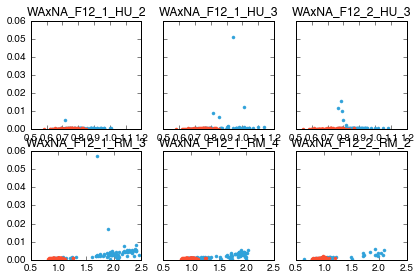

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), sharex='row', sharey='row')

groups_ph = pheno_df[pheno_df.population.isin(dict_panels.keys())].groupby(['selection','environment'])

for (ii, env) in enumerate(['HU','RM']):
    for jj, (population,gph) in enumerate(groups_ph.get_group((env,env)).groupby('population')):
        x = gph.pivot_table(columns='time', index='isolate', values='growth_rate', aggfunc=[np.mean, np.var])
        ax = axes[ii][dict_panels[population]]
        ax.plot(x['mean'], x['var'], '.')
        ax.set_title(population)

Fig. 3: Emergence of clones and de novo variation. (A and B) Competing clones experienced a variety of fates. Time is on the x-axis, starting after crossing when the population has no competing clones. Cumulative haplotype frequency of subclones is on the y-axis. Most commonly, selective sweeps were observed where a spontaneous mutation arose and increased in frequency. Driver mutations are colored according to their subclonal lineage assignments (see Methods). (C and D) Variability in intra-population growth rate $\mu_k(t)$, sampling $k$ isolates per population ($k=96$), per time-point . Mean growth rates  of the distribution modes are indicated as dashed lines.

## Figure SX - Sequence evolution of WA, NA founders

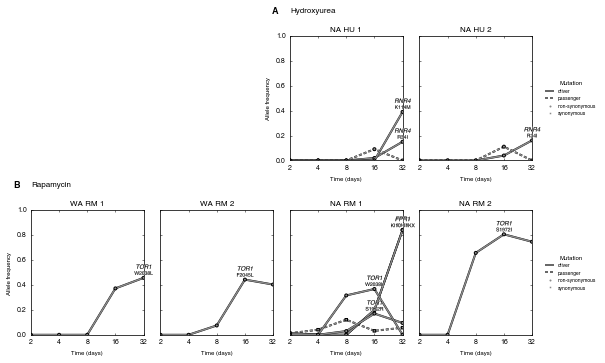

In [13]:
dict_panels = {
    'WA_HU_1':(0,0),
    'WA_HU_2':(0,1),
    'NA_HU_1':(0,2),
    'NA_HU_2':(0,3),
    'WA_RM_1':(0,0),
    'WA_RM_2':(0,1),
    'NA_RM_1':(0,2),
    'NA_RM_2':(0,3),
}
from matplotlib.ticker import MultipleLocator, FuncFormatter
from matplotlib.ticker import ScalarFormatter

groups_dn = seq_dn_df[(seq_dn_df.population.isin(dict_panels.keys()))&\
                      (seq_dn_df.clone=='')].groupby('selection')

# get a figure with a lot of subplots
fig = plt.figure(figsize=(8, 5), dpi=300)

grid = gridspec.GridSpec(2, 1, hspace=0.4)

gs = {}

for (ii, e) in enumerate(['HU','RM']):
    
    nrows = 1
    ncols = 4
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             wspace=0.15)

    ### de novo mutations ###
    for (jj, (p, gdn)) in enumerate(groups_dn.get_group(e).groupby('population')):
                
        # retrieve axes
        ax = plt.subplot(gs[e][dict_panels[p]])
        ax.set_title(p.replace('_',' '), fontsize=8)
        
#         # set panel labels
#         ax = plt.subplot(gs[e][((0,1) if e == 'HU' else (0,0))])
#         ax.text(-0.1, 1.2,  chr(ii + ord('A')), transform=ax.transAxes,
#                 fontsize=12, fontweight='bold', va='center', ha='right')
#         ax.text(0, 1.2,  dict_environment['short_label'][e], transform=ax.transAxes,
#                 fontsize=10, va='center', ha='left')
    
        # set axes labels
        if (e,p) in [('HU','NA_HU_1'),('RM','WA_RM_1')]:
            ax.set_ylabel('Allele frequency')
            ax.text(-0.1, 1.2, chr(ii + ord('A')), transform=ax.transAxes,
                    fontsize=9, fontweight='bold', va='center', ha='right')
            ax.text(0, 1.2,  config.dict_environment['short_label'][e], transform=ax.transAxes,
                    fontsize=8, va='center', ha='left')
        else:
            ax.set_yticklabels([])
        ax.set_xlabel('Time (days)')
        
        if (e,p) in [('HU','NA_HU_2'),('RM','NA_RM_2')]:
            driver_artist = lines.Line2D((0,1),(0,0), color=config.dict_lineages['bulk']['fill'], 
                                         **config.dict_mutation_type['driver'])
            passenger_artist = lines.Line2D((0,1),(0,0), color=config.dict_lineages['bulk']['fill'], 
                                            **config.dict_mutation_type['passenger'])
            nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.dict_lineages['bulk']['fill'],
                                         linestyle='', **config.dict_consequence_short['non-synonymous'])
            syn_artist = lines.Line2D((0,1),(0,0), mfc=config.dict_lineages['bulk']['fill'],
                                      linestyle='', **config.dict_consequence_short['synonymous'])
            leg1 = ax.legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.1, 0.5), ncol=1,
                             frameon=False, loc='center left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':5})
            plt.setp(leg1.get_title(),fontsize=6)

        for (gene, cds_pos, sub, protein_pos, amino_acids, consequence), gdx in \
    gdn.groupby(['gene','cds_position','substitution','protein_position','amino_acids','consequence_short']):
        
            assignment = gdx.assignment.unique()[0]
            mutation_type = gdx.mutation_type.unique()[0]

            gdx.time = gdx.time.apply(int)
            gdx = gdx.sort_values('time').reset_index(drop=True)
            gdx = gdx.sort_index()
            gdx = gdx.set_index('time')
            
            ax.plot(gdx.index, gdx.frequency,
                    color=config.dict_lineages['bulk']['line'], 
                    **utils.merge_two_dicts(config.dict_mutation_type[mutation_type],
                                            config.dict_consequence_short[consequence]))
            
            if mutation_type=='driver':
                index = np.argmax(gdx.frequency)
                ax.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                            textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                            path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                ax.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                            xy=(index,gdx.frequency[index]), fontsize=5,
                            textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                            path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)

# axes limits
for ax in fig.get_axes():
        
    # set scales
    ax.set_xlim(2, 32)
    ax.set_ylim(0, 1)
    
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
        
    ax.set_xscale('log', base=2)
    ax.set_xticks([2, 4, 8, 16, 32])
    ax.xaxis.set_major_formatter(ScalarFormatter())
#         # Place tickmarks at every multiple of 1, i.e. at any integer
#         ax.xaxis.set_major_locator(MultipleLocator(2))
#         # Format the ticklabel to be 2 raised to the power of `x`
#         ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: int(2**x)))
        # 
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        
    plt.setp(ax.get_xticklabels(), fontsize=7)
    plt.setp(ax.get_yticklabels(), fontsize=7)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)

fig.savefig(dir_supp+'figures/figureSX_seq_subclonal_dynamics/figureSX_seq_subclonal_dynamics_parents.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_seq_subclonal_dynamics/figureSX_seq_subclonal_dynamics_parents.svg', dpi=300, bbox_inches='tight')
plt.show()

In [213]:
dict_panels = {
    'NA_HU_1':(0,2),
    'NA_HU_2':(0,3),
    'WE_HU_1':(0,4),
    'WE_HU_2':(0,5),
    'SA_HU_1':(0,6),
    'SA_HU_2':(0,7),
    'WA_RM_1':(0,0),
    'WA_RM_2':(0,1),
    'NA_RM_1':(0,2),
    'NA_RM_2':(0,3),
    'WE_RM_1':(0,4),
    'WE_RM_2':(0,5),
    'SA_RM_1':(0,6),
    'SA_RM_2':(0,7)
}

df = seq_dn_df[(seq_dn_df.population.isin(dict_panels.keys()))]
# df = df[df.gene.isin(['RNR2','RNR4','FPR1','TOR1'])]
df[['dp_ref','dp_alt','time']] = df[['dp_ref','dp_alt','time']].astype(int)
df['dp_total'] = df['dp_ref']+df['dp_alt']

# Split delimited values in a DataFrame column into two new columns
# df['fwd_1'], df['fwd_2'], df['fwd_3'] = zip(*df['dp4'].apply(lambda x: x.split(',', 1)))
# zip(*df['dp4'].apply(lambda x: x.split(',')))

df = pd.pivot_table(df, index=['population','chrom','pos'], columns='time', values=['dp_alt','dp_total'])

# df = df.reorder_levels([1, 0], axis=1).sort_index(axis=1)

# for k,g in df.groupby(level='population'):
#     y=g.ix[k].fillna(0).reset_index()
#     y.astype(int).to_csv(dir_data+k+'.de_novo_counts.txt',header=False,index=False,sep='\t')


#.sort_values(axis=0)
# pd.pivot_table(df, index=['chrom','pos'], columns='time', values=['dp_alt','dp_total'])
# df.swaplevel(1, 2, axis=1)
# df.dp4.apply(lambda x: x.split(',', 1))
#sample['DP4'][2]+sample['DP4'][3]

# df.fwd_3
# zip(*df['dp4'].apply(lambda x: x.split(',',1)))

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Figure SX - Sequence evolution of WAxNA founders

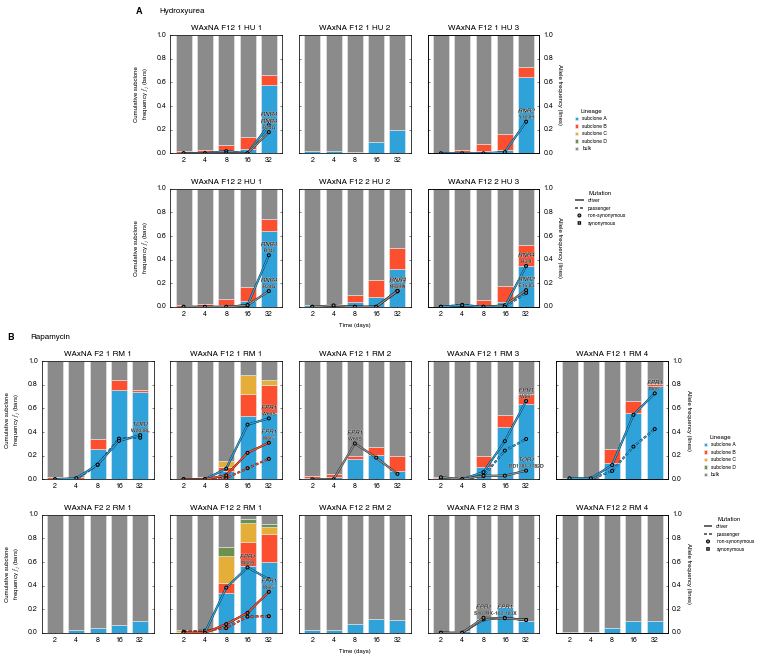

In [14]:
import collections

dict_panels = {
    'HU': {
        'WAxNA_F12_1_HU_1':(0,1), 
        'WAxNA_F12_1_HU_2':(0,2), 
        'WAxNA_F12_1_HU_3':(0,3), 
        'WAxNA_F12_2_HU_1':(1,1), 
        'WAxNA_F12_2_HU_2':(1,2), 
        'WAxNA_F12_2_HU_3':(1,3)
    },
    'RM': {
        'WAxNA_F2_1_RM_1':(0,0),
        'WAxNA_F12_1_RM_1':(0,1), 
        'WAxNA_F12_1_RM_2':(0,2), 
        'WAxNA_F12_1_RM_3':(0,3), 
        'WAxNA_F12_1_RM_4':(0,4),
        'WAxNA_F2_2_RM_1':(1,0),
        'WAxNA_F12_2_RM_1':(1,1), 
        'WAxNA_F12_2_RM_2':(1,2), 
        'WAxNA_F12_2_RM_3':(1,3), 
        'WAxNA_F12_2_RM_4':(1,4)
    }
}

populations = dict_panels['HU'].keys()+dict_panels['RM'].keys()
groups_st = seq_st_df[seq_st_df.population.isin(populations)].groupby(['selection','population'])
groups_dn = seq_dn_df[(seq_dn_df.population.isin(populations))&\
                      (seq_dn_df.clone=='')].groupby(['selection','population'])

# get a figure with a lot of subplots
fig = plt.figure(figsize=(10, 10), dpi=300)

grid = gridspec.GridSpec(2, 1)

gs = {}

for (ii, e) in enumerate(['HU','RM']):
    
    nrows = 2
    ncols = 5
    gs[e] = gridspec.GridSpecFromSubplotSpec(nrows, ncols,
                                             subplot_spec=grid[ii],
                                             hspace=0.3, wspace=0.15)
    
    for (jj, p) in enumerate(dict_panels[e]):
        
        # retrieve axes
        ax = plt.subplot(gs[e][dict_panels[e][p]])

        ### de novo mutations ###
        if (e,p) in groups_dn.groups.keys():

            gdn = groups_dn.get_group((e,p))
            
            for (gene, pos, cds, sub, protein_pos, amino_acids, consequence), gdx \
            in gdn.groupby(['gene','pos','cds_position','substitution','protein_position','amino_acids','consequence_short']):

                assignment = gdx.assignment.unique()[0]
                mutation_type = gdx.mutation_type.unique()[0]
            
                gdx.time = gdx.time.apply(int)
                gdx = gdx.sort_values('time').reset_index(drop=True)
                gdx = gdx.sort_index()

                ax.plot(gdx.index.values, gdx.frequency.values,
                        color=config.dict_lineages[assignment]['line'],
                        **utils.merge_two_dicts(config.dict_mutation_type[mutation_type],
                                                config.dict_consequence_short[consequence]))
            
                if mutation_type=='driver':
                    index = np.argmax(gdx.frequency)
                    ax.annotate(gene, xy=(index,gdx.frequency[index]), style='italic', fontsize=6,
                                textcoords='offset points', xytext=(0, 13), ha = 'center', va = 'top',
                                path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")], zorder=3)
                    ax.annotate(amino_acids.split('/')[0]+protein_pos+amino_acids.split('/')[1], 
                                xy=(index,gdx.frequency[index]), fontsize=5,
                                textcoords='offset points', xytext=(0, 7), ha = 'center', va = 'top',
                                path_effects=[PathEffects.withStroke(linewidth=0.4, foreground="w")], zorder=3)

        ### subclone frequency ###
        gst = groups_st.get_group((e,p))
        
        # 
        ax.set_title(p.replace('_',' '), fontsize=8)
        # 
        gst = gst.set_index('time')
        gst = gst[['subclone A','subclone B','subclone C','subclone D','bulk']]
        gst.plot(ax=ax, kind='bar',
                 legend=False, stacked=True, width=0.75, position=0.5,
                 color=[config.dict_lineages[c]['fill'] for c in gst.columns])
        
        # rotate the x-axis ticks
        plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
        ax.set_xlabel('')
        
        # legends
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4')]:
            
            leg1 = ax.legend(bbox_to_anchor=(1.3, 0), ncol=1,
                             frameon=False, loc='lower left', 
                             borderaxespad=0., handlelength=0.7, 
                             title='Lineage', prop={'size':5})
            plt.setp(leg1.get_title(),fontsize=6)
    
        if (e,p) in [('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
            
            driver_artist = lines.Line2D((0,1),(0,0), color=config.dict_lineages['bulk']['fill'], 
                                         **config.dict_mutation_type['driver'])
            passenger_artist = lines.Line2D((0,1),(0,0), color=config.dict_lineages['bulk']['fill'], 
                                            **config.dict_mutation_type['passenger'])
            nonsyn_artist = lines.Line2D((0,1),(0,0), mfc=config.dict_lineages['bulk']['fill'], linestyle='',
                                         path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                         **config.dict_consequence_short['non-synonymous'])
            syn_artist = lines.Line2D((0,1),(0,0), mfc=config.dict_lineages['bulk']['fill'], linestyle='', 
                                      path_effects=[PathEffects.withStroke(linewidth=2, foreground="k")],
                                      **config.dict_consequence_short['synonymous'])
            leg2 = ax.legend([driver_artist,passenger_artist,nonsyn_artist,syn_artist], 
                             ['driver','passenger','non-synonymous','synonymous'], 
                             bbox_to_anchor=(1.3, 1), ncol=1,
                             frameon=False, loc='upper left',
                             borderaxespad=0, handlelength=1.75, 
                             title='Mutation', prop={'size':5})
            plt.setp(leg2.get_title(),fontsize=6)

        if (e,p) in [('HU','WAxNA_F12_2_HU_2'),('RM','WAxNA_F12_2_RM_2')]:
            ax.set_xlabel('Time (days)')
        if (e,p) in [('HU','WAxNA_F12_1_HU_1'),('RM','WAxNA_F2_1_RM_1'),
                     ('HU','WAxNA_F12_2_HU_1'),('RM','WAxNA_F2_2_RM_1')]:
            ax.set_ylabel('Cumulative subclone\n frequency $f_j$ (bars)')
        elif (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_4'),
                       ('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4')]:
            ax.set_yticklabels([])
            ax.twinx().set_ylabel('Allele frequency (lines)', rotation=270, va='baseline')
#             plt.setp( ax.twinx().xaxis.get_majorticklabels(), rotation=0 )
        else:
            ax.set_yticklabels([])

    # set panel labels
    ax = plt.subplot(gs[e][((0,1) if e == 'HU' else (0,0))])
    ax.text(-0.25, 1.2,  chr(ii + ord('A')), transform=ax.transAxes,
            fontsize=9, fontweight='bold', va='center', ha='right')
    ax.text(-0.1, 1.2,  config.dict_environment['short_label'][e], transform=ax.transAxes,
            fontsize=8, va='center', ha='left')
    
# axes limits
for ax in fig.get_axes():
            
    ax.set_ylim(0, 1)

    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
        
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        
    plt.setp(ax.get_xticklabels(), fontsize=7)
    plt.setp(ax.get_yticklabels(), fontsize=7)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(.75)

fig.savefig(dir_supp+'figures/figureSX_seq_subclonal_dynamics/figureSX_seq_subclonal_dynamics_cross.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_seq_subclonal_dynamics/figureSX_seq_subclonal_dynamics_cross.svg', dpi=300, bbox_inches='tight')
plt.show()

## Figure SX - Phenotype evolution

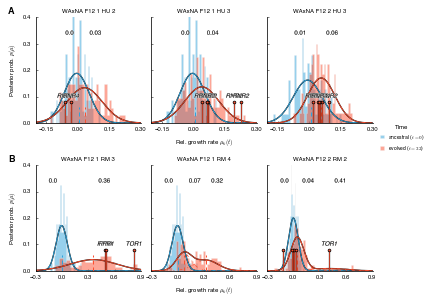

In [23]:
dict_panels = {
    'WAxNA_F12_1_HU_2':(0,0),
    'WAxNA_F12_1_HU_3':(0,1),
    'WAxNA_F12_2_HU_3':(0,2),
    'WAxNA_F12_1_RM_3':(1,0),
    'WAxNA_F12_1_RM_4':(1,1),
    'WAxNA_F12_2_RM_2':(1,2)
}

from scipy import stats

groups_ph = pheno_df[pheno_df.population.isin(dict_panels.keys())]
groups_ph = groups_ph.groupby(['selection'])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(6, 4), dpi=300, sharex='row', sharey='row')
    
fig.subplots_adjust(left=0.07,bottom=0.07,right=0.85,top=0.95,hspace=0.4,wspace=0.1)

for (ii, env) in enumerate(['HU','RM']):
    
    for (jj, (population,gph)) in enumerate(groups_ph.get_group(env).groupby('population')):
        
        # retrieve axes
        ax1 = axes[dict_panels[population]]
        utils.simple_axes(ax1)
        if env=='HU':
            ax1.set_xlim(-0.2, 0.3)
            ax1.set_ylim(0, 0.4)
        elif env=='RM':
            ax1.set_xlim(-0.3, 0.9)
            ax1.set_ylim(0, 0.4)

        # take rows where param is finite
        gph = gph[np.isfinite(gph[param])]
        # set reference as mean phenotype of the ancestral hybrid
        ref = gph.groupby('group').get_group('ancestral')[param].mean()
        gph.loc[:,param] = gph[param] - ref
                
        for (kk, ((time),g3)) in enumerate(gph.groupby('group')):
            
            data = g3.groupby(['isolate']).agg([np.mean])
            X = data[param]['mean'][:, np.newaxis]

            ax1.set_title(population.replace('_',' '), fontsize=6)
            
            # plot data
            bins = 36
            xbins, y = plot.histogram_binned_data(ax1, X, bins=bins)

#             ax1.plot(xbins, y, linewidth=.7)
                        
            ax1.fill_between(xbins, 0, y, label=config.dict_population['long_label'][time], 
                             alpha=0.5, facecolor=config.dict_population['color'][time])

            N = np.arange(1, 6)
            
            models = model.gmm_fit(X, N)

            # compute the AIC and the BIC
            AIC = [m.aic(X) for m in models]
            BIC = [m.bic(X) for m in models]
            
            M_best = models[np.argmin(BIC)]
            
            xbins = np.linspace(ax1.get_xlim()[0], ax1.get_xlim()[1], 1000)
            logprob, responsibilities = M_best.score_samples(np.array([xbins]).T)
            pdf = np.exp(logprob)
            pdf_individual = responsibilities * pdf[:, np.newaxis] 
            
            ax1.plot(xbins, pdf / bins, '-', 
                     color=config.dict_population['color'][time], lw=.75,
                     path_effects=[PathEffects.withStroke(linewidth=1.25, foreground='k')])
            ax1.plot(xbins, pdf_individual / bins, '-.', 
                     color=config.dict_population['color'][time], lw=.75)

            # mean of the distribution
            for p in abs(M_best.means_.ravel()):
                ax1.plot( [p,p], ax.get_ylim(), 
                        color=config.dict_population['color'][time], 
                        linestyle='--', dashes=(4,3), linewidth=1)
                pos = ax1.get_ylim()[0] * 0.75 + ax1.get_ylim()[1] * 0.25
                trans = ax1.get_xaxis_transform() # x in data units, y in axes fraction
                ax1.annotate(np.around(p, 2),
                            xy=(p, 0.85), xycoords=trans, fontsize=6,
                            color='k', va='center',
                            ha=('right' if time=='ancestral' else 'left'),
                            xytext=((-5 if time=='ancestral' else 5),0), textcoords='offset points',
                            path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])
                
            # mean of sequenced isolates       
            data_ys = g3[(g3['group']=='evolved')&\
                         (g3['assignment']!='')].groupby(['isolate','gene','genotype_long','assignment'])
            
            data_ys = data_ys.agg([np.mean, np.median, np.std, 'count'])
            
            if len(data_ys)>0:
            
                x_data = np.array(data_ys[param]['mean'])
                y_data = np.repeat([0.2*(ax1.get_ylim()[1]-ax1.get_ylim()[0])], len(x_data))
                arr = zip(x_data, y_data)
            
                markerline, stemlines, baseline = ax1.stem(x_data, y_data)
                
                plt.setp(markerline, 'color', config.dict_population['color'][time], 
                         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
                plt.setp(stemlines, linewidth=.75, color=config.dict_population['color'][time],
                         path_effects=[PathEffects.withStroke(linewidth=1.25, foreground='k')], zorder=2)  
                plt.setp(baseline, 'color', 'none', zorder=1)
                    
            for idx, label in data_ys.iterrows():
                ax1.annotate(label.name[1], 
                             xy = (label[param]['mean'], 0.2), xycoords=('data','axes fraction'), 
                             xytext = (0, 8), textcoords = 'offset points', 
                             ha = 'center', va = 'top',
                             fontsize = 6, style = 'italic',
                             path_effects=[PathEffects.withStroke(linewidth=0.5, foreground="w")])

# draw legend
leg = axes[0, 2].legend(bbox_to_anchor=(1.05, -0.15), frameon=False,
                        loc='center left', borderaxespad=0.,
                        handlelength=0.75, title='Time', prop={'size':5})
plt.setp(leg.get_title(),fontsize=6)

# set axes labels
for ii in [0, 1]:
    axes[ii, 1].set_xlabel(r'Rel. growth rate $\mu_{k}(t)$')
    axes[ii, 0].set_ylabel(r'Posterior prob. $p(\mu)$')

# set panel labels
axes[0][0].text(-0.2, 1.1,  chr(ord('A')), transform=axes[0][0].transAxes,
                fontsize=9, fontweight='bold', va='top', ha='right')
axes[1][0].text(-0.2, 1.1,  chr(ord('B')), transform=axes[1][0].transAxes,
                fontsize=9, fontweight='bold', va='top', ha='right')
        
# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
    
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(0.75)
        
    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
    
fig.savefig(dir_supp+'figures/figureSX_pheno_evolution/figureSX_pheno_evolution.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_pheno_evolution/figureSX_pheno_evolution.svg', dpi=300, bbox_inches='tight')
plt.show()

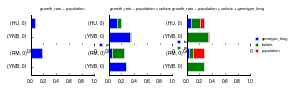

In [217]:
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(2, 5), sharex=True, sharey=True)

pdf = pheno_df
pdf = pdf[np.isfinite(pdf['growth_rate'])]

fig = plt.figure(figsize=(6, 1), dpi=300)

import matplotlib.gridspec as gridspec
    
formulas = ['growth_rate ~ population',
            'growth_rate ~ population + isolate',
            'growth_rate ~ population + isolate + genotype_long']

grid = gridspec.GridSpec(nrows=1, ncols=5, hspace=0.2, wspace=0.22)

gs = {}
for ii in np.arange(len(formulas)):
    gs[ii] = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[ii], hspace=0)

for ii, formula in enumerate(formulas):
    
    msdf = pdf.groupby(['selection','environment']).apply(model.variance_vectors, formula) 
    tsdf = pdf.groupby(['selection','environment']).apply(model.variance_vectors, formula) 
    df = tsdf#pd.concat([tsdf, thdf], keys=['spores','hybrids'], names=['type'])
    
    # fix index
#     df = df.swaplevel('type', 'env_evo')
#     df = df.swaplevel('type', 'env_test')
#     df = df.sort_index(level=['env_evo','env_test','type'])
    
    # fix columns
    df = df.rename(columns={'C(spore)':'spore'})
  
    df = df.sort_index(axis=1)
#     order = ['background','de_novo_gene','de_novo_genotype','auxotrophy','tetrad','spore']
#     order = pd.Series(list(set(order) & set(df.columns)))
#     df = df[order]
    
    ax1 = plt.subplot(gs[ii][0])
    utils.simple_axes(ax1)
    
    s = df.ix['HU']
    s = s.sort_index(ascending=False)
    s.plot(ax=ax1, kind='barh', stacked=True, 
#            color=[factor_dict['color'][x] for x in s.columns],
           align='center', legend=False, width=0.75)
    
#     bars = ax1.patches
#     hatches = ''.join([factor_dict['hatch'][x] for x in s.index.get_level_values('type')]*len(s)*2)

#     for bar, hatch in zip(bars, hatches):
#         bar.set_hatch(hatch)
    
    ax1.set_title(formula, fontsize=4)
#     ax1.set_xlabel('')
#     ax1.set_xticks([])
#     ax1.set_xticklabels([])    
#     ystart, yend, ylabels = set_custom_labels(s.index, 0)
#     ax1.set_yticks(ylabels.values(), minor=False)
#     ax1.set_yticklabels(ylabels.keys(), minor=False, fontsize=5)
        
    ax2 = plt.subplot(gs[ii][1])
    utils.simple_axes(ax2)
    
    h = df.ix['RM']
    h = h.sort_index(ascending=False)
    h.plot(ax=ax2, kind='barh', stacked=True, 
#            color=[factor_dict['color'][x] for x in h.columns],
           align='center', legend=False, width=0.75)
    
#     bars = ax2.patches
#     hatches = ''.join([factor_dict['hatch'][x] for x in h.index.get_level_values('type')]*len(h)*2)

#     for bar, hatch in zip(bars, hatches):
#         bar.set_hatch(hatch)
    
#     ax2.set_xlabel('Variance', fontsize=5)    
#     ystart, yend, ylabels = set_custom_labels(h.index, 0)
#     ax2.set_yticks(ylabels.values(), minor=False)
#     ax2.set_yticklabels(ylabels.keys(), minor=False, fontsize=5)
    
    for ax in [ax1,ax2]:
        ax.set_xlim((0,1))
#         ax.set_yticks([])
#         ax.set_yticklabels([])
        ax.set_ylabel('', fontsize=6)

    leg2 = ax2.legend(bbox_to_anchor=(1.05, 1.0), frameon=False,
                      loc='center left', borderaxespad=0.,
                      handlelength=0.75, prop={'size':4})
    
for ax in fig.get_axes():        
        
    plt.setp(ax.get_xticklabels(), fontsize=5)
    plt.setp(ax.get_yticklabels(), fontsize=5)
    
    ax.tick_params(size=2)
        
    for loc in ['top','bottom','left','right']:
        ax.spines[loc].set_linewidth(1)

fig.savefig(dir_supp+'figures/figureSX_pheno_evolution/figureSX_pheno_evolution_anova.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_supp+'figures/figureSX_pheno_evolution/figureSX_pheno_evolution_anova.svg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from matplotlib.colors import LogNorm

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GMM(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20.0, 30.0)
y = np.linspace(-20.0, 40.0)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)[0]
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.hist(X_train[:, 0], X_train[:, 1])

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()